In [10]:
import pandas as pd
import os
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
import warnings
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
import numpy as np
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('float_format', '{:f}'.format)

In [11]:
data_train = pd.read_parquet('../data/processed/train.gzip')
data_sub = pd.read_parquet('../data/processed/test.gzip')

data_train.columns = [col.replace('-', '_') for col in data_train.columns]
data_sub.columns = [col.replace('-', '_') for col in data_sub.columns]

# list(data_train.columns)

In [12]:
data_sub_id = data_sub[['ID']]

categorical_feats = ['CO_TIPO_SEXO', 'NO_DEPARTAMENTO', 'REGION', 
                     'SALDO_PEQ_EMP_FLAG_any', 'SALDO_MED_EMP_FLAG_any', 'SALDO_MIC_EMP_FLAG_any',
                     'CANT_EMP_NEG_FLAG_any','CANT_EMP_CONS_FLAG_any', 'CANT_EMP_HIPOT_FLAG_any', 'NO_PROVINCIA'
                     ]
for col in categorical_feats:
    data_train[col] = data_train[col].astype('category')
    data_sub[col] = data_sub[col].astype('category')

TARGET_VAR = 'TARGET'
N_FOLDS = 5
N_JOBS = os.cpu_count() // 2.5

In [13]:
selected_cols = [
 TARGET_VAR,
 'NO_PROVINCIA',
 'CO_TIPO_SEXO',
 'EDAD',
 'NO_DEPARTAMENTO',
 'MESES_HASTA_ACTUAL',
 'CANT_EMP_NEG_max',
 'CANT_EMP_NEG_last',
 'CANT_EMP_NEG_min',
 'CANT_EMP_CONS_max',
 'CANT_EMP_CONS_last',
 'CANT_EMP_CONS_min',
 'CANT_EMP_HIPOT_max',
 'CANT_EMP_HIPOT_last',
 'CANT_EMP_HIPOT_min',
 'SALDO_MED_EMP_mean',
 'SALDO_MED_EMP_median',
 'SALDO_MED_EMP_last',
 'SALDO_MED_EMP_min',
 'SALDO_MED_EMP_max',
 'SALDO_MED_EMP_first',
 'SALDO_PEQ_EMP_mean',
 'SALDO_PEQ_EMP_median',
 'SALDO_PEQ_EMP_last',
 'SALDO_PEQ_EMP_min',
 'SALDO_PEQ_EMP_max',
 'SALDO_PEQ_EMP_first',
 'SALDO_MIC_EMP_mean',
 'SALDO_MIC_EMP_median',
 'SALDO_MIC_EMP_last',
 'SALDO_MIC_EMP_min',
 'SALDO_MIC_EMP_max',
 'SALDO_MIC_EMP_first',
 'SALDO_CONS_REV_mean',
 'SALDO_CONS_REV_median',
 'SALDO_CONS_REV_last',
 'SALDO_CONS_REV_min',
 'SALDO_CONS_REV_max',
 'SALDO_CONS_REV_first',
 'SALDO_CONS_NO_REV_mean',
 'SALDO_CONS_NO_REV_median',
 'SALDO_CONS_NO_REV_last',
 'SALDO_CONS_NO_REV_min',
 'SALDO_CONS_NO_REV_max',
 'SALDO_CONS_NO_REV_first',
 'SALDO_HIPOT_mean',
 'SALDO_HIPOT_median',
 'SALDO_HIPOT_last',
 'SALDO_HIPOT_min',
 'SALDO_HIPOT_max',
 'SALDO_HIPOT_first',
 'SALDO_VENCIDO_mean',
 'SALDO_VENCIDO_median',
 'SALDO_VENCIDO_last',
 'SALDO_VENCIDO_min',
 'SALDO_VENCIDO_max',
 'SALDO_VENCIDO_first',
 'CANT_EMP_DOL_NEG_mean',
 'CANT_EMP_DOL_NEG_median',
 'CANT_EMP_DOL_NEG_last',
 'CANT_EMP_DOL_NEG_min',
 'CANT_EMP_DOL_NEG_max',
 'CANT_EMP_DOL_NEG_first',
 'SALDO_DOLA_NEG_mean',
 'SALDO_DOLA_NEG_median',
 'SALDO_DOLA_NEG_last',
 'SALDO_DOLA_NEG_min',
 'SALDO_DOLA_NEG_max',
 'SALDO_DOLA_NEG_first',
 'CANT_EMP_DOL_CONS_mean',
 'CANT_EMP_DOL_CONS_median',
 'CANT_EMP_DOL_CONS_last',
 'CANT_EMP_DOL_CONS_min',
 'CANT_EMP_DOL_CONS_max',
 'CANT_EMP_DOL_CONS_first',
 'SALDO_DOLA_CONS_mean',
 'SALDO_DOLA_CONS_median',
 'SALDO_DOLA_CONS_last',
 'SALDO_DOLA_CONS_min',
 'SALDO_DOLA_CONS_max',
 'SALDO_DOLA_CONS_first',
 'CANT_EMP_DOL_HIPOT_mean',
 'CANT_EMP_DOL_HIPOT_median',
 'CANT_EMP_DOL_HIPOT_last',
 'CANT_EMP_DOL_HIPOT_min',
 'CANT_EMP_DOL_HIPOT_max',
 'CANT_EMP_DOL_HIPOT_first',
 'SALDO_DOLA_HIPOT_mean',
 'SALDO_DOLA_HIPOT_median',
 'SALDO_DOLA_HIPOT_last',
 'SALDO_DOLA_HIPOT_min',
 'SALDO_DOLA_HIPOT_max',
 'SALDO_DOLA_HIPOT_first',
 'MAX_LINEA_DISP_U6M_mean',
 'MAX_LINEA_DISP_U6M_median',
 'MAX_LINEA_DISP_U6M_last',
 'MAX_LINEA_DISP_U6M_min',
 'MAX_LINEA_DISP_U6M_max',
 'MAX_LINEA_DISP_U6M_first',
 'SALDO_EMP_TOTAL_mean',
 'SALDO_EMP_TOTAL_last',
 'SALDO_EMP_TOTAL_max',
 'SALDO_EMP_TOTAL_min',
 'SALDO_EMP_TOTAL_median',
 'VAR_SALDO_EMP_TOTAL_1_mean',
 'VAR_SALDO_EMP_TOTAL_1_median',
 'VAR_SALDO_EMP_TOTAL_MA3_mean',
 'VAR_SALDO_EMP_TOTAL_MA3_median',
 'VAR_SALDO_EMP_TOTAL_MA6_mean',
 'VAR_SALDO_EMP_TOTAL_MA6_median',
 'VAR_SALDO_EMP_TOTAL_MA8_mean',
 'VAR_SALDO_EMP_TOTAL_MA8_median',
 'VAR_SALDO_EMP_TOTAL_VENCIDO_1_mean',
 'VAR_SALDO_EMP_TOTAL_VENCIDO_1_median',
 'VAR_SALDO_EMP_TOTAL_VENCIDO_MA3_mean',
 'VAR_SALDO_EMP_TOTAL_VENCIDO_MA3_median',
 'VAR_SALDO_EMP_TOTAL_VENCIDO_MA6_mean',
 'VAR_SALDO_EMP_TOTAL_VENCIDO_MA6_median',
 'VAR_SALDO_EMP_TOTAL_VENCIDO_MA8_mean',
 'VAR_SALDO_EMP_TOTAL_VENCIDO_MA8_median',
 'DIFF_SALDO_EMP_TOTAL_1_mean',
 'DIFF_SALDO_EMP_TOTAL_1_median',
 'DIFF_SALDO_EMP_TOTAL_MA3_mean',
 'DIFF_SALDO_EMP_TOTAL_MA3_median',
 'DIFF_SALDO_EMP_TOTAL_MA6_mean',
 'DIFF_SALDO_EMP_TOTAL_MA6_median',
 'DIFF_SALDO_EMP_TOTAL_MA8_mean',
 'DIFF_SALDO_EMP_TOTAL_MA8_median',
 'DIFF_SALDO_EMP_TOTAL_VENCIDO_1_mean',
 'DIFF_SALDO_EMP_TOTAL_VENCIDO_1_median',
 'DIFF_SALDO_EMP_TOTAL_VENCIDO_MA3_mean',
 'DIFF_SALDO_EMP_TOTAL_VENCIDO_MA3_median',
 'DIFF_SALDO_EMP_TOTAL_VENCIDO_MA6_mean',
 'DIFF_SALDO_EMP_TOTAL_VENCIDO_MA6_median',
 'DIFF_SALDO_EMP_TOTAL_VENCIDO_MA8_mean',
 'DIFF_SALDO_EMP_TOTAL_VENCIDO_MA8_median',
 'DIFF_MAX_LINEA_DISP_U6M_1_mean',
 'DIFF_MAX_LINEA_DISP_U6M_1_median',
 'DIFF_MAX_LINEA_DISP_U6M_MA3_mean',
 'DIFF_MAX_LINEA_DISP_U6M_MA3_median',
 'DIFF_MAX_LINEA_DISP_U6M_MA6_mean',
 'DIFF_MAX_LINEA_DISP_U6M_MA6_median',
 'DIFF_MAX_LINEA_DISP_U6M_MA8_mean',
 'DIFF_MAX_LINEA_DISP_U6M_MA8_median',
 'VAR_SALDO_REV_NO_REV_VENCIDO_1_mean',
 'VAR_SALDO_REV_NO_REV_VENCIDO_1_median',
 'VAR_SALDO_REV_NO_REV_VENCIDO_MA3_mean',
 'VAR_SALDO_REV_NO_REV_VENCIDO_MA3_median',
 'VAR_SALDO_REV_NO_REV_VENCIDO_MA6_mean',
 'VAR_SALDO_REV_NO_REV_VENCIDO_MA6_median',
 'VAR_SALDO_REV_NO_REV_VENCIDO_MA8_mean',
 'VAR_SALDO_REV_NO_REV_VENCIDO_MA8_median',
 'VAR_SALDO_TOTAL_VENCIDO_1_mean',
 'VAR_SALDO_TOTAL_VENCIDO_1_median',
 'VAR_SALDO_TOTAL_VENCIDO_MA3_mean',
 'VAR_SALDO_TOTAL_VENCIDO_MA3_median',
 'VAR_SALDO_TOTAL_VENCIDO_MA6_mean',
 'VAR_SALDO_TOTAL_VENCIDO_MA6_median',
 'VAR_SALDO_TOTAL_VENCIDO_MA8_mean',
 'VAR_SALDO_TOTAL_VENCIDO_MA8_median',
 'VAR_MAX_LINEA_DISP_U6M_1_mean',
 'VAR_MAX_LINEA_DISP_U6M_1_median',
 'VAR_MAX_LINEA_DISP_U6M_MA3_mean',
 'VAR_MAX_LINEA_DISP_U6M_MA3_median',
 'VAR_MAX_LINEA_DISP_U6M_MA6_mean',
 'VAR_MAX_LINEA_DISP_U6M_MA6_median',
 'VAR_MAX_LINEA_DISP_U6M_MA8_mean',
 'VAR_MAX_LINEA_DISP_U6M_MA8_median',
 'VAR_SALDO_DOLA_TOTAL_1_mean',
 'VAR_SALDO_DOLA_TOTAL_1_median',
 'VAR_SALDO_DOLA_TOTAL_MA3_mean',
 'VAR_SALDO_DOLA_TOTAL_MA3_median',
 'VAR_SALDO_DOLA_TOTAL_MA6_mean',
 'VAR_SALDO_DOLA_TOTAL_MA6_median',
 'VAR_SALDO_DOLA_TOTAL_MA8_mean',
 'VAR_SALDO_DOLA_TOTAL_MA8_median',
 'DIFF_SALDO_DOLA_TOTAL_1_mean',
 'DIFF_SALDO_DOLA_TOTAL_1_median',
 'DIFF_SALDO_DOLA_TOTAL_MA3_mean',
 'DIFF_SALDO_DOLA_TOTAL_MA3_median',
 'DIFF_SALDO_DOLA_TOTAL_MA6_mean',
 'DIFF_SALDO_DOLA_TOTAL_MA6_median',
 'DIFF_SALDO_DOLA_TOTAL_MA8_mean',
 'DIFF_SALDO_DOLA_TOTAL_MA8_median',
 'SALDO_PEQ_EMP_FLAG_any',
 'SALDO_MED_EMP_FLAG_any',
 'SALDO_MIC_EMP_FLAG_any',
 'CANT_EMP_NEG_FLAG_any',
 'CANT_EMP_CONS_FLAG_any',
 'CANT_EMP_HIPOT_FLAG_any',
 'PROXY_MOROSIDAD_1_mean',
 'PROXY_MOROSIDAD_1_median',
 'PROXY_MOROSIDAD_2_mean',
 'PROXY_MOROSIDAD_2_median',
 'PROXY_MOROSIDAD_3_mean',
 'PROXY_MOROSIDAD_3_median',

    # 'PROXY_MOROSIDAD_1_mean', 'PROXY_MOROSIDAD_2_mean', 'PROXY_MOROSIDAD_3_mean',
    # 'DIFF_MAX_LINEA_DISP_U6M_MA8_mean',
    # 'VAR_MAX_LINEA_DISP_U6M_MA8_mean',
    # 'SALDO_PEQ_EMP_FLAG_any', 'SALDO_MED_EMP_FLAG_any', 'SALDO_MIC_EMP_FLAG_any',
    # 'CANT_EMP_NEG_FLAG_any','CANT_EMP_CONS_FLAG_any', 'CANT_EMP_HIPOT_FLAG_any',
    # 'VAR_SALDO_DOLA_TOTAL_MA8_mean',
    # 'DIFF_SALDO_EMP_TOTAL_VENCIDO_1_mean',
    # 'DIFF_SALDO_EMP_TOTAL_MA3_mean',
    # 'SALDO_EMP_TOTAL_min', 'SALDO_EMP_TOTAL_max', 'DIFF_SALDO_EMP_TOTAL_MA8_mean', 
    # 'SALDO_DOLA_CONS_mean',
    # 'CANT_EMP_NEG_min',
    # 'SALDO_CONS_REV_mean',
    # 'SALDO_VENCIDO_mean', 'SALDO_VENCIDO_max', 'SALDO_VENCIDO_min', 'SALDO_VENCIDO_last', 'SALDO_VENCIDO_first',
    # 'MAX_LINEA_DISP_U6M_max', 
    # 'CO_TIPO_SEXO',
    # 'MESES_HASTA_ACTUAL',
    # 'EDAD',
    # 'NO_DEPARTAMENTO',
    # 'REGION', TARGET_VAR
]

data_train =  data_train.select_dtypes(include=['int64', 'float64', 'category'])
data_train = data_train[selected_cols]

data_sub = data_sub.select_dtypes(include=['int64', 'float64', 'category'])
data_sub = data_sub[selected_cols]

list(data_train.columns)
print(data_train.dtypes)

TARGET                         int64
NO_PROVINCIA                category
CO_TIPO_SEXO                category
EDAD                         float64
NO_DEPARTAMENTO             category
                              ...   
PROXY_MOROSIDAD_1_median     float64
PROXY_MOROSIDAD_2_mean       float64
PROXY_MOROSIDAD_2_median     float64
PROXY_MOROSIDAD_3_mean       float64
PROXY_MOROSIDAD_3_median     float64
Length: 196, dtype: object


In [14]:
data_train[TARGET_VAR].value_counts(normalize=True)

0   0.849994
1   0.150006
Name: TARGET, dtype: float64

In [15]:
import xgboost as xgb

def get_xgboost_model():
    return xgb.XGBClassifier(
        n_estimators=200, 
        max_depth=8, 
        learning_rate=0.1, 
        objective='binary:logistic', 
        booster='gbtree', 
        tree_method='auto', 
        n_jobs=-1, 
        verbosity=0, 
        enable_categorical=True,
        random_state=42
    )

def get_catboost_model(cat_features):
    return CatBoostClassifier(
        iterations=500, 
        depth=8, 
        learning_rate=0.1, 
        loss_function='Logloss', 
        eval_metric='F1', 
        random_seed=42, 
        verbose=0, 
        cat_features=cat_features,
        thread_count=N_JOBS, 
    )


              precision    recall  f1-score   support

           0       0.92      0.91      0.91     15501
           1       0.52      0.56      0.54      2736

    accuracy                           0.86     18237
   macro avg       0.72      0.73      0.73     18237
weighted avg       0.86      0.86      0.86     18237

              precision    recall  f1-score   support

           0       0.92      0.90      0.91     15501
           1       0.51      0.57      0.54      2736

    accuracy                           0.85     18237
   macro avg       0.72      0.74      0.73     18237
weighted avg       0.86      0.85      0.86     18237

              precision    recall  f1-score   support

           0       0.92      0.91      0.92     15501
           1       0.53      0.57      0.55      2736

    accuracy                           0.86     18237
   macro avg       0.73      0.74      0.74     18237
weighted avg       0.87      0.86      0.86     18237

              preci

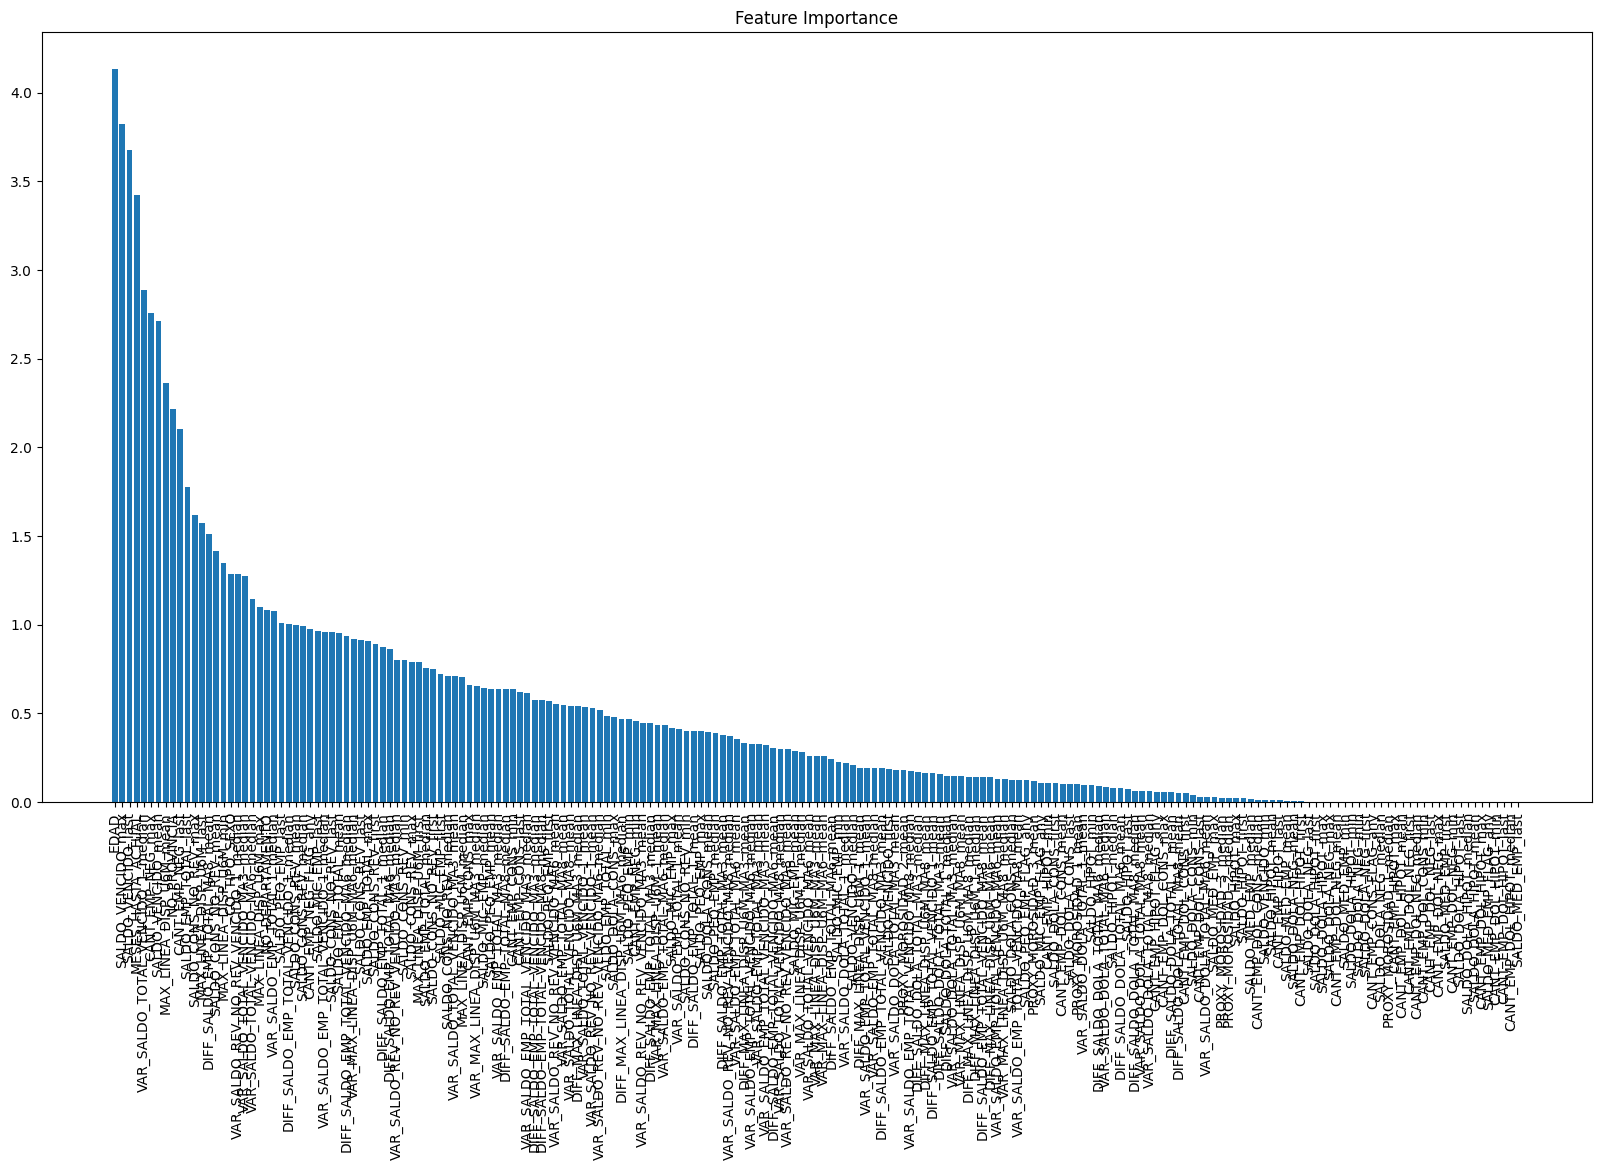

In [16]:
data_copy = data_train.copy()

X = data_train.drop(columns=[TARGET_VAR])
y = data_train[TARGET_VAR]
FACTOR = 0.25

cat_features = X.select_dtypes(include=['category']).columns.tolist()

skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=42)

f1_macros = []
for train_idx, test_idx in skf.split(X, y):
    cat_model = get_catboost_model(cat_features)
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    cat_model.fit(X_train, y_train)
    y_pred = cat_model.predict_proba(X_test)[:, 1]
    y_pred = (y_pred > FACTOR).astype(int)
    print(classification_report(y_test, y_pred))
    
    f1_macros.append(f1_score(y_test, y_pred, average='macro'))

print(f'Mean F1 macro: {np.mean(f1_macros):.3f}')
cat_model = get_catboost_model(cat_features)
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)
cat_model.fit(X_train, y_train)

# cat_model feature importance
importances = cat_model.feature_importances_
indices = np.argsort(importances)[::-1]

# print feature ranking
print("Feature ranking:")
for f in range(X.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, X.columns[indices[f]], importances[indices[f]]))
# plot feature importance
plt.figure(figsize=(20, 10))
plt.title("Feature Importance")
plt.bar(range(X.shape[1]), importances[indices])
plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)
plt.show()

In [17]:
FACTOR = 0.25

data_copy['PRED'] = cat_model.predict_proba(data_copy.drop(columns=[TARGET_VAR]))[:, 1]
data_copy['PRED'] = (data_copy['PRED'] > FACTOR).astype(int)

data_sub['TARGET'] = cat_model.predict_proba(data_sub.drop(columns=[TARGET_VAR]))[:, 1]
data_sub['TARGET'] = (data_sub['TARGET'] > FACTOR).astype(int)

print(classification_report(data_copy[TARGET_VAR], data_copy['PRED']))

              precision    recall  f1-score   support

           0       0.95      0.94      0.94     77505
           1       0.65      0.70      0.68     13678

    accuracy                           0.90     91183
   macro avg       0.80      0.82      0.81     91183
weighted avg       0.90      0.90      0.90     91183



In [18]:
submission = pd.concat([data_sub_id, data_sub['TARGET']], axis=1)
print(submission['TARGET'].value_counts(normalize=True))

# submission.to_csv('../data/results/catboost_all.csv', index=False)

0   0.836615
1   0.163385
Name: TARGET, dtype: float64
